**THE BACKTESTING RESULTS AND EQUITY CURVE ARE AT THE END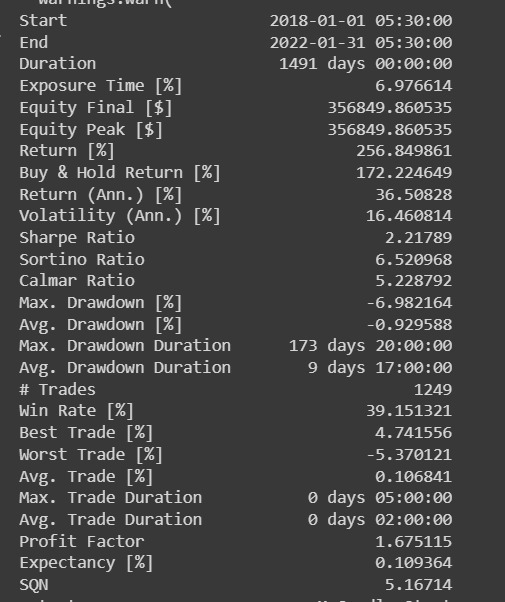**

# Resistance/Support AND Candles Patterns

In [1]:
import pandas as pd
df = pd.read_csv("/content/btc_1h.csv")

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

datetime      open      high       low     close      volume
35657  2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45  1037.92256
35658  2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   874.06052
35659  2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   734.65855
35660  2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76  1728.81180
35661  2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30  2907.71096

In [2]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df1.head(1)

open      high       low     close      volume
datetime                                                               
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199

In [3]:
df.set_index(df['datetime'],inplace=True)

In [4]:
df1=df.drop(columns='datetime')

In [ ]:
df.describe()

open          high           low         close        volume
count  35662.000000  35662.000000  35662.000000  35662.000000  35662.000000
mean   18807.837000  18918.878088  18688.322415  18808.483922   2275.191054
std    17870.446911  17977.848712  17756.123684  17870.684086   2182.125572
min     3172.620000   3184.750000   3156.260000   3172.050000      4.635181
25%     7135.817500   7166.652500   7098.757500   7135.980000   1062.930808
50%     9531.895000   9577.165000   9486.600000   9531.830000   1659.340727
75%    32699.775000  32933.000000  32396.307500  32701.625000   2704.322946
max    68635.120000  69000.000000  68451.190000  68633.690000  47255.762685

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35662 entries, 0 to 35661
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  35662 non-null  datetime64[ns]
 1   open      35662 non-null  float64       
 2   high      35662 non-null  float64       
 3   low       35662 non-null  float64       
 4   close     35662 non-null  float64       
 5   volume    35662 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.6 MB


# Support and Resistance FUNCTIONS

In [6]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [7]:
length = len(df1)
high = list(df1['high'])
low = list(df1['low'])
close = list(df1['close'])
open = list(df1['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0

def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0

def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df1.high[l]-min(levels, key=lambda x:abs(x-df1.high[l])))<=lim
    c2 = abs(max(df1.open[l],df1.close[l])-min(levels, key=lambda x:abs(x-df1.high[l])))<=lim
    c3 = min(df1.open[l],df1.close[l])<min(levels, key=lambda x:abs(x-df1.high[l]))
    c4 = df1.low[l]<min(levels, key=lambda x:abs(x-df1.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df1.low[l]-min(levels, key=lambda x:abs(x-df1.low[l])))<=lim
    c2 = abs(min(df1.open[l],df1.close[l])-min(levels, key=lambda x:abs(x-df1.low[l])))<=lim
    c3 = max(df1.open[l],df1.close[l])>min(levels, key=lambda x:abs(x-df1.low[l]))
    c4 = df1.high[l]>min(levels, key=lambda x:abs(x-df1.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [8]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df1)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df1, subrow, n1, n2):
            ss.append(df1.low[subrow])
        if resistance(df1, subrow, n1, n2):
            rr.append(df1.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df1.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df1.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [9]:
df1['signal']=signal

In [10]:
df1[df1['signal']==2].count()

open      688
high      688
low       688
close     688
volume    688
signal    688
dtype: int64

In [11]:
df1.columns = [ 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
df1

Open      High       Low     Close       Volume  \
datetime                                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01   443.356199   
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   383.697006   
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   429.064572   
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   420.087030   
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   340.807329   
...                       ...       ...       ...       ...          ...   
2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45  1037.922560   
2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   874.060520   
2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   734.658550   
2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76  1728.811800   
2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30  2907.710960   

                     signal  
datetime                     
2018-01-01 05:30:00       0  
2018-01-01 06:30:00       0  
2018-01-01 07:30:00       0  
2018-01-01 08:30:00       0  
2018-01-01 09:30:00       0  
...                     ...  
2022-01-31 01:30:00       0  
2022-01-31 02:30:00       0  
2022-01-31 03:30:00       0  
2022-01-31 04:30:00       0  
2022-01-31 05:30:00       0  

[35662 rows x 6 columns]

In [12]:
def SIGNAL():
    return df1.signal

In [ ]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient,
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row),
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True).
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin
#with more fine-grained (e.g. hourly) data.

In [13]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=3586a8de3302ea0db1017c255557ff23038288da1aeb2aa018a7a0b230ddf760
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [14]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        if self.signal1 == 2:
            # Long trade
            sl1 = self.data.Close[-1] - 750e-4
            limit1 = self.data.Close[-1]  # Adjust as needed
            tp1 = self.data.Close[-1] + 600e-4

            # Ensure correct order parameters
            self.buy(sl=sl1, limit=limit1, tp=tp1)

        elif self.signal1 == 1:
            # Short trade
            sl1 = self.data.Close[-1] + 750e-4
            limit1 = self.data.Close[-1]  # Adjust as needed
            tp1 = self.data.Close[-1] - 600e-4

            # Ensure correct order parameters
            self.sell(sl=sl1, limit=limit1, tp=tp1)


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [15]:
from backtesting import Backtest

bt = Backtest(df1, MyCandlesStrat, cash=100000, commission=.0015)
stat = bt.run()
stat



/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:912: UserWarning: (2018-01-03 01:30:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:912: UserWarning: (2018-01-03 09:30:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119
  warnings.warn(
/usr/local/lib/python3.10/di

Start                     2018-01-01 05:30:00
End                       2022-01-31 05:30:00
Duration                   1491 days 00:00:00
Exposure Time [%]                    6.976614
Equity Final [$]                356849.860535
Equity Peak [$]                 356849.860535
Return [%]                         256.849861
Buy & Hold Return [%]              172.224649
Return (Ann.) [%]                    36.50828
Volatility (Ann.) [%]               16.460814
Sharpe Ratio                          2.21789
Sortino Ratio                        6.520968
Calmar Ratio                         5.228792
Max. Drawdown [%]                   -6.982164
Avg. Drawdown [%]                   -0.929588
Max. Drawdown Duration      173 days 20:00:00
Avg. Drawdown Duration        9 days 17:00:00
# Trades                                 1249
Win Rate [%]                        39.151321
Best Trade [%]                       4.741556
Worst Trade [%]                     -5.370121
Avg. Trade [%]                    

In [16]:
import matplotlib.pyplot as plt
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '4H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in

GridPlot(id='p1351', ...)